# **1.Importing Libraries**

In [42]:
import os 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169

## GPU CUDA setup check

In [43]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **2. Creating datasets**

In [24]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32): 

    '''fetch all out test data from directory'''

    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

    return train_data, val_data

In [4]:
folder_path = './COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128, batch_size = 32)

Found 14819 images belonging to 4 classes.
Found 6348 images belonging to 4 classes.


# **3.Data Analysis**

In [26]:
class_names = train_data.class_indices
print(class_names)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [27]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [28]:
images,labels = next(train_data)
labels = np.argmax(labels, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

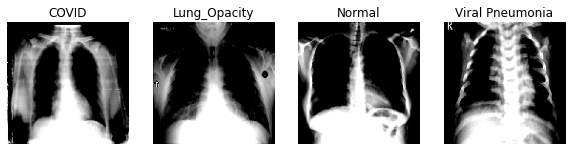

In [37]:
#Lets visualize the augmented images
plt.figure(figsize=(10, 10))
for image in images:
    j  = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k])
                plt.title(classes[i])
                plt.axis("off")
                break
        j = j+1
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 1.8736 and the minimum is -2.4302
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


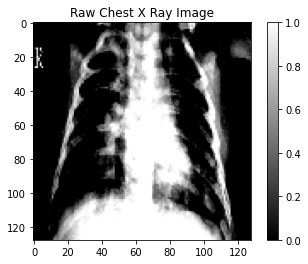

In [9]:
# Investing single image
raw_image = images[k]
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

c:\users\haejo\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

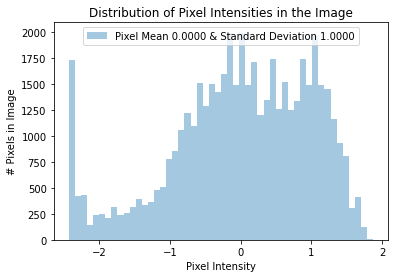

In [10]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [11]:
all_items,dirs,files = next(os.walk(folder_path))

In [12]:
image_in_classes = []
for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(folder_path,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)    
    

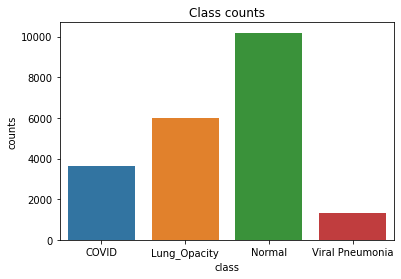

In [13]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

# **4. CNN and ResNet50**

### Using Convolutional Neural Networks

In [39]:
def plotLearningCurve(history, epochs):
    epochRange = range(1,epochs+1)
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
    ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('Epoch', fontsize = 20)
    ax[0].set_ylabel('Accuracy', fontsize = 20)
    ax[0].legend()
    ax[0].grid(color='gray', linestyle='--')
    ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
    ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch', fontsize = 20)
    ax[1].set_ylabel('Loss', fontsize = 20)
    ax[1].legend()
    ax[1].grid(color='gray', linestyle='--')
    plt.show()

In [40]:
def cnn_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    i = Input(shape=(size,size,3)) #defining input
    x = BatchNormalization()(i)
    x = Conv2D(32,3, activation= 'relu')(i) #adding convolution layers
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()
    #Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 
    

In [41]:
epochs = 20
r,model,n_epochs = cnn_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                            

In [17]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

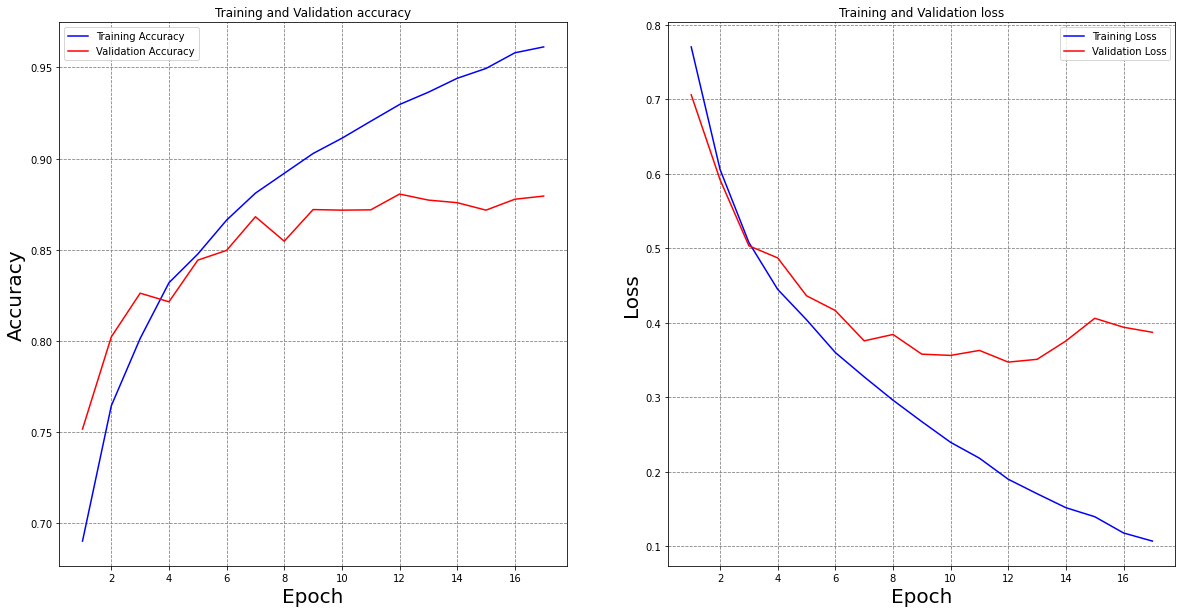

In [18]:
plotLearningCurve(r,n_epochs)

In [19]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 14s 72ms/step - loss: 0.3473 - accuracy: 0.8806
Test Accuracy using CNN: 88.06%
464/464 [==============================] - 34s 74ms/step - loss: 0.1560 - accuracy: 0.9479
Train Accuracy using CNN: 94.79%


### Using ResNet50 with imagenet weights (pre-trained model from Keras)

In [20]:
def resnet_model(train_data,test_data, epochs,size):
    print("----Building the model----")
    
    base_model = ResNet50(input_shape= (size,size,3), include_top=False) # weights = 'imagenet' (default)

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model=Model(inputs=base_model.input,outputs=out) 
    # model.summary()

    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)

    mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [21]:
epochs = 10
r,model,n_epochs = resnet_model(train_data, val_data,epochs,128)

----Building the model----
94781440/94765736 [==============================] - 1s 0us/step
----Training the network----
Epoch 1/10

Epoch 00001: val_loss improved from inf to 2.06293, saving model to resnet_model.h5


c:\users\haejo\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


464/464 - 114s - loss: 0.3441 - accuracy: 0.8717 - val_loss: 2.0629 - val_accuracy: 0.3741 - 114s/epoch - 245ms/step
Epoch 2/10

Epoch 00002: val_loss improved from 2.06293 to 0.45650, saving model to resnet_model.h5
464/464 - 101s - loss: 0.1558 - accuracy: 0.9453 - val_loss: 0.4565 - val_accuracy: 0.8370 - 101s/epoch - 218ms/step
Epoch 3/10

Epoch 00003: val_loss improved from 0.45650 to 0.29556, saving model to resnet_model.h5
464/464 - 102s - loss: 0.0947 - accuracy: 0.9661 - val_loss: 0.2956 - val_accuracy: 0.8959 - 102s/epoch - 219ms/step
Epoch 4/10

Epoch 00004: val_loss improved from 0.29556 to 0.22757, saving model to resnet_model.h5
464/464 - 102s - loss: 0.0787 - accuracy: 0.9721 - val_loss: 0.2276 - val_accuracy: 0.9227 - 102s/epoch - 220ms/step
Epoch 5/10

Epoch 00005: val_loss did not improve from 0.22757
464/464 - 100s - loss: 0.0535 - accuracy: 0.9803 - val_loss: 0.3317 - val_accuracy: 0.9227 - 100s/epoch - 216ms/step
Epoch 6/10

Epoch 00006: val_loss did not improve fr

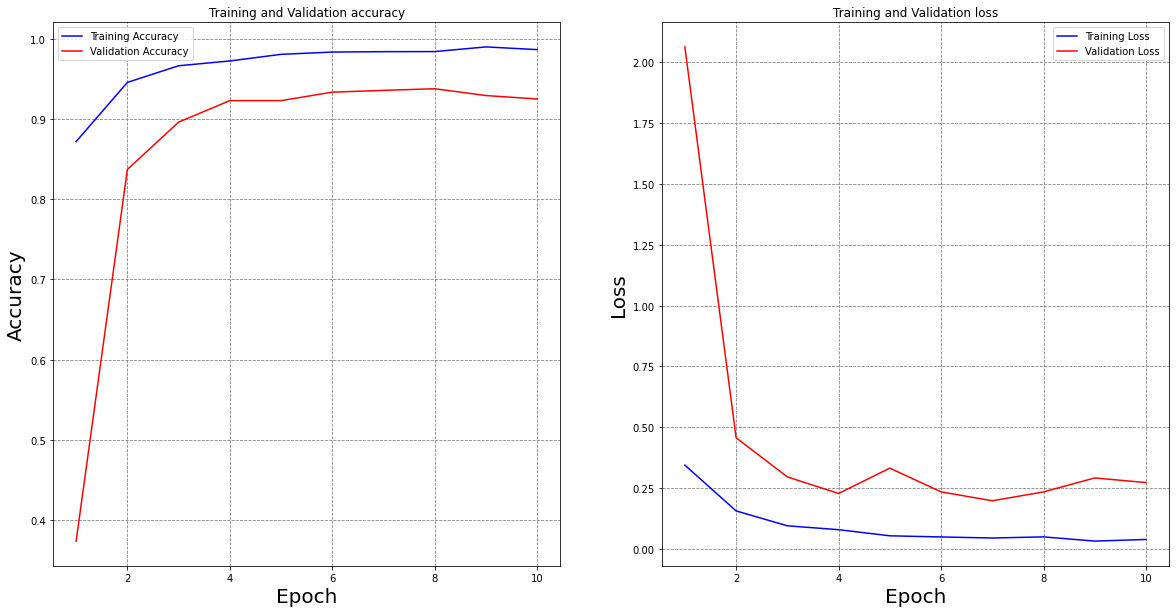

In [22]:
plotLearningCurve(r,n_epochs)

In [23]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using ResNet50: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using ResNet50: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 15s 75ms/step - loss: 0.2723 - accuracy: 0.9247
Test Accuracy using ResNet50: 92.47%
464/464 [==============================] - 35s 75ms/step - loss: 0.0468 - accuracy: 0.9825
Train Accuracy using ResNet50: 98.25%


### 